# **Manpower Planning**
## **Using Competency Assessment Method with Gurobi Framework**

_by: TK-Bunga Matahari Team_

---

# **Manpower Planning Objectives and Process**

## *The Objectives*

1. Optimizing the Use of Human Resources
2. Minimizing Recruitment Costs
3. Meeting Future Workforce Needs
4. Maintaining an Adequate Workforce

## *The Process*

1. Determine The Company’s Targets and Goals
	- How does a company optimize the workforce with the initial fund of $10.000?
2. Assess Current Workforce
	- Distribution of employees in these work units
	- Distribution of employees that have high/low skill value
	- Distribution of under-qualified and overqualified employees
3.
	- Distribution of  Forecast Future Needs
	- Workload Analysis
	- Workforce Analysis
	- Trend Analysis
4. Gap Analysis
	- Assessing the current status of current workforce and determining where company want to be in the future


# 0. The Obligatory Part


In [473]:
import ast
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

# 1. Define the Data Structure

## 1.1. Employee and Task Data

In [474]:
# Run this if the data in Local/Repository
new_employee_path = "./data/fixed_data_employee.csv"
new_task_path = "./data/fixed_data_task.csv"

In [475]:
# Read data
employee_skills_df = pd.read_csv(new_employee_path, index_col='No')
# employee_skills_df.drop(columns=['no'], inplace=True, errors='ignore')

employees = employee_skills_df.index.tolist()
skills_name = employee_skills_df.columns[2:].tolist()

employee_skills_df

,employee_id,Role,Mathematics.Linear Algebra,Mathematics.Differential Equations,Mathematics.Optimization Technique,Mathematics.Calculus,Mathematics.Combinatorics & Graph,Statistics & Probabilities.Statistics,Statistics & Probabilities.Probability & Sampling,Statistics & Probabilities.Bayessian Method,...,Data & Cloud Engineering.Data Security & Privacy,Data & Cloud Engineering.Distributed Systems,"Data & Cloud Engineering.Monitoring, Logging, Alerting",MLOPS.ML Lifecycle,MLOPS.ML Model Pipeline,MLOPS.Model Versioning,MLOPS.Automated Testing & Validation,MLOPS.Scalable Model Training,"MLOPS.Model Deployment, Monitoring, Logging",MLOPS.Ethical AI & Bias Mitigation
No,,,,,,,,,,,,,,,,,,,,,
1,Talent 1,Data Scientist,1,1,2,1,2,3,3,2,...,1,1,1,2,1,1,1,1,1,2
2,Talent 2,Data Scientist,4,4,4,4,3,5,4,3,...,3,2,1,1,1,1,1,1,1,1
3,Talent 3,Data Analyst,3,2,2,3,2,3,3,2,...,3,3,3,3,2,3,2,3,3,2
4,Talent 4,Data Scientist,3,2,3,2,3,4,3,2,...,3,1,1,2,2,2,2,2,2,2
5,Talent 5,Data Analyst,2,1,3,1,1,1,2,1,...,2,1,1,3,2,5,2,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,Talent 107,Data Analyst,1,4,4,3,4,3,4,4,...,5,5,5,3,5,3,4,3,4,2
106,Talent 108,Data Analyst,3,3,3,3,4,2,2,2,...,4,3,4,2,3,3,2,2,3,2
107,Talent 109,Data Engineer,5,5,4,5,3,4,4,3,...,5,5,5,5,5,5,5,5,5,5


## 1.2. Optimization Output Data

In [476]:
result_moo = pd.read_csv('./output_VM/3_gap_0.025/result_5_MOO_2.csv')
result_moo.head()

,employee,company,assigned_task,sum_sp,wasted_sp,assessment_score
0,Talent 1,['P3'],['T270'],8,12,[-0.027166504381694268]
1,Talent 2,"['P3', 'P3']","['T97', 'T166']",11,9,"[-0.017692307692307688, -0.017582417582417582]"
2,Talent 3,"['P2', 'P2']","['T201', 'T297']",11,9,"[-0.01773854560739807, -0.011648351648351648]"
3,Talent 4,"['P5', 'P5']","['T153', 'T296']",10,10,"[-0.01749788672865596, -0.011564986737400529]"
4,Talent 5,['P4'],['T39'],8,12,[-0.029608127721335267]


## 1.3. Estimated Salary Data

In [477]:
salary_job_df = pd.read_csv('./data/linreg_salary_job.csv')
salary_job_df.head()

,job_role,junior,middle,senior
0,Artificial intelligence,"15,359,986","20,517,907","34,001,747"
1,Data Analyst,"10,361,232","15,519,153","29,002,993"
2,Data Engineer,"13,996,396","19,154,317","32,638,157"
3,Data Scientist,"16,557,921","21,715,842","35,199,682"


In [478]:
job_roles = salary_job_df['job_role'].unique()
levels = {
    'junior': salary_job_df['junior'],
    'middle': salary_job_df['middle'],
    'senior': salary_job_df['senior']
}
levels

{'junior': 0    15,359,986
 1    10,361,232
 2    13,996,396
 3    16,557,921
 Name: junior, dtype: object,
 'middle': 0    20,517,907
 1    15,519,153
 2    19,154,317
 3    21,715,842
 Name: middle, dtype: object,
 'senior': 0    34,001,747
 1    29,002,993
 2    32,638,157
 3    35,199,682
 Name: senior, dtype: object}

## 1.4. Company Targets

In [479]:
initial_fund = 10000 # USD

# 2. Assess Current Workforce

Using Exploratory Data Analysis (EDA), we can analyze the distribution and the insight of our current data and optimization result

## 2.1. The Distribution of Employees respect to Role

To see how much the employees we have by Role

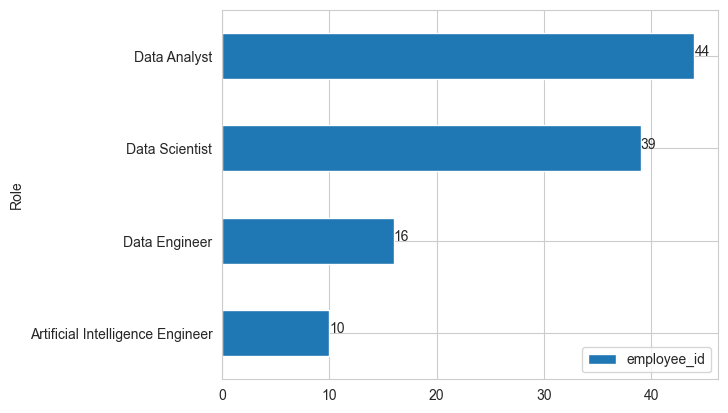

In [480]:
# Plot the horizontal bar chart
ax = employee_skills_df[['Role','employee_id']].groupby('Role', as_index=False).count().sort_values('employee_id',ascending=True)\
.plot(kind='barh', x = 'Role')

# Annotate the values on each bar
for index, value in enumerate(employee_skills_df[['Role','employee_id']].groupby('Role', as_index=False).count().sort_values('employee_id',ascending=True)\
['employee_id']):
    ax.text(value, index, str(value))

plt.show()

## 2.2. The Distribution Respect to Good Skill Value (3-5)

Value 3-5 can we consider that employees have a good skill in that competency

In [481]:
for skill in skills_name:
	j_good_skill = round(len(employee_skills_df[(employee_skills_df[skill] <= 5) & (employee_skills_df[skill] >= 3)]) / len(employees) * 100, 2)
	print(f"{skill}: {j_good_skill}%")

Mathematics.Linear Algebra: 73.39%
Mathematics.Differential Equations: 65.14%
Mathematics.Optimization Technique: 65.14%
Mathematics.Calculus: 66.97%
Mathematics.Combinatorics & Graph: 61.47%
Statistics & Probabilities.Statistics: 89.91%
Statistics & Probabilities.Probability & Sampling: 82.57%
Statistics & Probabilities.Bayessian Method: 55.96%
Statistics & Probabilities.Hypothesis Testing: 67.89%
Statistics & Probabilities.A/B Testing: 64.22%
Statistics & Probabilities.CUPED: 47.71%
Data Structures & Algorithms.Complexity Analysis: 68.81%
Data Structures & Algorithms.Programming: 91.74%
Data Structures & Algorithms.Data Structures: 91.74%
Data Structures & Algorithms.Algorithms: 88.99%
Data Structures & Algorithms.Advanced Algorithms: 69.72%
Data Structures & Algorithms.SQL: 99.08%
Data Structures & Algorithms.Shell / Bash Scripting: 73.39%
Econometrics, Data Analysis, and Data Visualization.Data Preprocessing & EDA: 97.25%
Econometrics, Data Analysis, and Data Visualization.Data Viz

It is interesting to explore more on certain parts tailored to the role (example: MLOPS - AI, does the percentage of each MLOPS skill match the amount of AI available, or is there a significant difference?)

### 2.2.1. Data Analyst Distribution

The skills mastered by 50% of the population of each role will be explored.

In [482]:
# Data Analyst
print(f"Total Data Analyst percentage in population: {len(employee_skills_df[employee_skills_df['Role']=='Data Analyst'])/len(employee_skills_df)*100}%")
for skill in skills_name:
  if round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                   (employee_skills_df[skill]>=3)&
                  (employee_skills_df['Role']=='Data Analyst')])/112*100,2) >= (42*0.6):
    print(skill,': ',f"""{round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                    (employee_skills_df[skill]>=3)&
                    (employee_skills_df['Role']=='Data Analyst')])/112*100,2)}%""")

Total Data Analyst percentage in population: 40.36697247706422%
Statistics & Probabilities.Statistics :  33.93%
Statistics & Probabilities.Probability & Sampling :  27.68%
Statistics & Probabilities.Hypothesis Testing :  25.89%
Data Structures & Algorithms.Programming :  32.14%
Data Structures & Algorithms.Data Structures :  33.93%
Data Structures & Algorithms.Algorithms :  31.25%
Data Structures & Algorithms.SQL :  38.39%
Econometrics, Data Analysis, and Data Visualization.Data Preprocessing & EDA :  36.61%
Econometrics, Data Analysis, and Data Visualization.Data Viz & Storytelling :  35.71%
Econometrics, Data Analysis, and Data Visualization.Regression Analysis :  30.36%
Econometrics, Data Analysis, and Data Visualization.Time Series Analysis :  28.57%
Econometrics, Data Analysis, and Data Visualization.Correlation Analysis :  30.36%
Data & Cloud Engineering.Relational DB :  33.04%


dari skill-skill yang dikuasai oleh kurang lebih 60% Data Analyst:
- Data Analyst menguasai beberapa topic: Statistics & Probabilities (3/6), Data Structures & Algorithms (4/7), Econometrics, Data Analysis, and Data Visualization (5/8), Relational DB.
- Dari topic Statistics & Probabilities, banyak talent kita yang menguasai Statistics, sementara lebih sedikit untuk skill Probability & Sampling dan Hypothesis Testing (mungkin dikarenakan use case di telkom belum mengerjakan A/B Testing)
- Dari topic Data Structures & Algorithms, talent kita sangat menguasai SQL, Data Structures, Programming, dan Algorithms.
- Dari topic Econometrics, Data Analysis, and Data Visualization, talent kita sangat menguasai Data Preprocessing & EDA, Data Viz & Storytelling, Regression Analysis, Time Series Analysis, and Correlation Analysis.
- Dari topic Data & Cloud Engineering, talent kita hanya menguasai Relational DB.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13000\2153803459.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(skill_da_percentages, shade=True, color='skyblue')


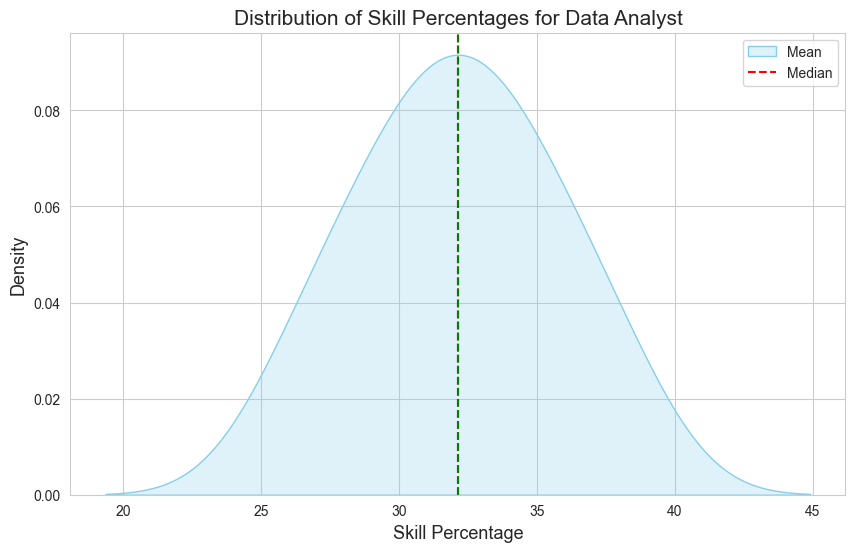

In [483]:
# Create a list to store the percentages of each skill
skill_da_percentages = []

for skill in skills_name:
  skill_percentage = round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                   (employee_skills_df[skill]>=3)&
                   (employee_skills_df['Role']=='Data Analyst')])/112*100,2)
  
  if skill_percentage >= (42*0.6):
    # print(skill,': ',f"{skill_percentage}%")
    skill_da_percentages.append(skill_percentage)

# Create a distribution plot of the skill percentages
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.kdeplot(skill_da_percentages, shade=True, color='skyblue')
plt.axvline(x=np.mean(skill_da_percentages), color='red', linestyle='--')
plt.axvline(x=np.median(skill_da_percentages), color='green', linestyle='--')
plt.legend(['Mean', 'Median'])


# Add labels and title
plt.xlabel('Skill Percentage', size=13)
plt.ylabel('Density', size=13)
plt.title('Distribution of Skill Percentages for Data Analyst', size=15)
plt.show()

### 2.2.2. Data Scientist Distribution

In [484]:
# Data Scientist
print(f"Total Data Scientist percentage in population: {len(employee_skills_df[employee_skills_df['Role']=='Data Scientist'])/len(employee_skills_df)*100}%")
for skill in skills_name:
  if round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                   (employee_skills_df[skill]>=3)&
                  (employee_skills_df['Role']=='Data Scientist')])/112*100,2) >= (35*0.6):
    print(skill,': ',f"""{round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                    (employee_skills_df[skill]>=3)&
                    (employee_skills_df['Role']=='Data Scientist')])/112*100,2)}%""")

Total Data Scientist percentage in population: 35.77981651376147%
Mathematics.Linear Algebra :  31.25%
Mathematics.Differential Equations :  29.46%
Mathematics.Optimization Technique :  27.68%
Mathematics.Calculus :  29.46%
Mathematics.Combinatorics & Graph :  25.89%
Statistics & Probabilities.Statistics :  34.82%
Statistics & Probabilities.Probability & Sampling :  33.93%
Statistics & Probabilities.Bayessian Method :  26.79%
Statistics & Probabilities.Hypothesis Testing :  28.57%
Statistics & Probabilities.A/B Testing :  26.79%
Data Structures & Algorithms.Complexity Analysis :  25.89%
Data Structures & Algorithms.Programming :  33.93%
Data Structures & Algorithms.Data Structures :  32.14%
Data Structures & Algorithms.Algorithms :  32.14%
Data Structures & Algorithms.Advanced Algorithms :  23.21%
Data Structures & Algorithms.SQL :  34.82%
Data Structures & Algorithms.Shell / Bash Scripting :  24.11%
Econometrics, Data Analysis, and Data Visualization.Data Preprocessing & EDA :  34.82%

dari skill-skill yang dikuasai oleh kurang lebih 60% Data Scientist:
- Data scientist hampir menguasai semua topic kecuali MLOps.
- Dari topic **Mathematics**, hampir semua skill dikuasai talent dengan **Combinatorics & Graph** menjadi skill yang paling sedikit dibanding skill lain.
- Dari topic **Statistics & Probabilities**, hampir semua menguasai **Statistics** dan **Probability & Sampling**.
- Dari topic **Data Structures & Algorithms**, talent kita sangat menguasai SQL, Data Structures, Programming, dan Algorithms.
- Dari topic Econometrics, Data Analysis, and Data Visualization, talent kita sangat menguasai Data Preprocessing & EDA, Data Viz & Storytelling, Regression Analysis, Time Series Analysis, and Correlation Analysis.
- Dari topic Data & Cloud Engineering, talent kita hanya menguasai Relational DB.

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13000\2902651876.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(skill_ds_percentages, shade=True, color='skyblue')


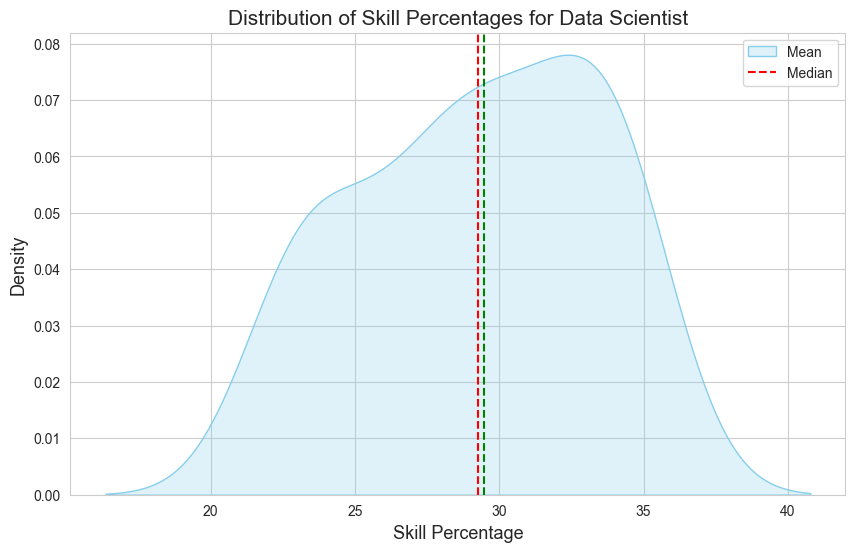

In [485]:
# make distribution plot for Data Scientist
skill_ds_percentages = []

for skill in skills_name:
    skill_percentage = round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                     (employee_skills_df[skill]>=3)&
                     (employee_skills_df['Role']=='Data Scientist')])/112*100,2)
    
    if skill_percentage >= (35*0.6):
        # print(skill,': ',f"{skill_percentage}%")
        skill_ds_percentages.append(skill_percentage)

# Create a distribution plot of the skill percentages
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.kdeplot(skill_ds_percentages, shade=True, color='skyblue')
plt.axvline(x=np.mean(skill_ds_percentages), color='red', linestyle='--')
plt.axvline(x=np.median(skill_ds_percentages), color='green', linestyle='--')
plt.legend(['Mean', 'Median'])

# Add labels and title
plt.xlabel('Skill Percentage', size=13)
plt.ylabel('Density', size=13)
plt.title('Distribution of Skill Percentages for Data Scientist', size=15)
plt.show()

### 2.2.3. Data Engineer Distribution

In [486]:
# Data Engineer
print(f"Total Data Engineer percentage in population: {len(employee_skills_df[employee_skills_df['Role']=='Data Engineer'])/len(employee_skills_df)*100}%")
for skill in skills_name:
  if round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                   (employee_skills_df[skill]>=3)&
                  (employee_skills_df['Role']=='Data Engineer')])/112*100,2) >= 7:
    print(skill,': ',f"""{round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                    (employee_skills_df[skill]>=3)&
                    (employee_skills_df['Role']=='Data Engineer')])/112*100,2)}%""")

Total Data Engineer percentage in population: 14.678899082568808%
Mathematics.Linear Algebra :  8.04%
Mathematics.Calculus :  7.14%
Statistics & Probabilities.Statistics :  9.82%
Statistics & Probabilities.Probability & Sampling :  9.82%
Data Structures & Algorithms.Complexity Analysis :  13.39%
Data Structures & Algorithms.Programming :  14.29%
Data Structures & Algorithms.Data Structures :  14.29%
Data Structures & Algorithms.Algorithms :  14.29%
Data Structures & Algorithms.Advanced Algorithms :  11.61%
Data Structures & Algorithms.SQL :  14.29%
Data Structures & Algorithms.Shell / Bash Scripting :  14.29%
Econometrics, Data Analysis, and Data Visualization.Data Preprocessing & EDA :  14.29%
Econometrics, Data Analysis, and Data Visualization.Data Viz & Storytelling :  11.61%
Econometrics, Data Analysis, and Data Visualization.Regression Analysis :  8.93%
Econometrics, Data Analysis, and Data Visualization.Time Series Analysis :  9.82%
Econometrics, Data Analysis, and Data Visualiza

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13000\2024926811.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(skill_de_percentages, shade=True, color='skyblue')


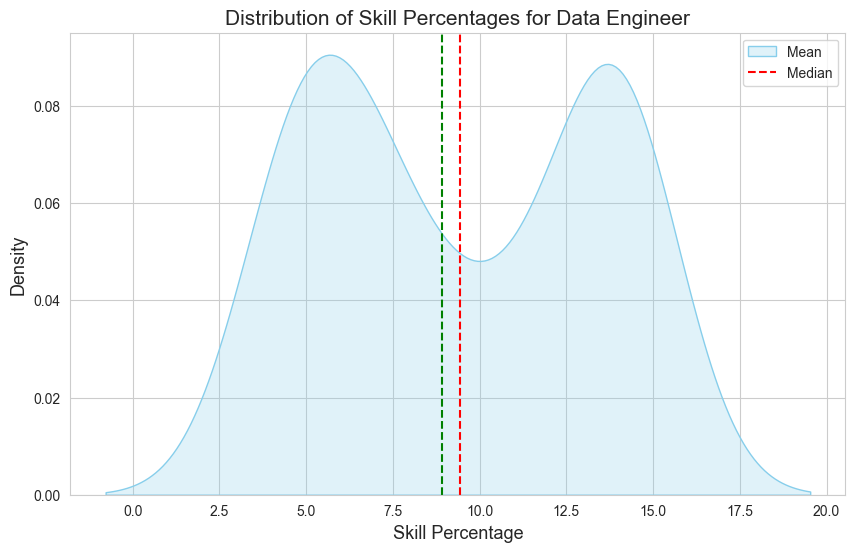

In [487]:
# make distribution plot for Data Engineer
skill_de_percentages = []

for skill in skills_name:
    skill_percentage = round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                     (employee_skills_df[skill]>=3)&
                     (employee_skills_df['Role']=='Data Engineer')])/112*100,2)
    
    if skill_percentage >= 4:
        # print(skill,': ',f"{skill_percentage}%")
        skill_de_percentages.append(skill_percentage)

# Create a distribution plot of the skill percentages
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.kdeplot(skill_de_percentages, shade=True, color='skyblue')
plt.axvline(x=np.mean(skill_de_percentages), color='red', linestyle='--')
plt.axvline(x=np.median(skill_de_percentages), color='green', linestyle='--')
plt.legend(['Mean', 'Median'])

# Add labels and title
plt.xlabel('Skill Percentage', size=13)
plt.ylabel('Density', size=13)
plt.title('Distribution of Skill Percentages for Data Engineer', size=15)
plt.show()

### 2.2.4. Artificial Intelligence Distribution

In [488]:
# AI Engineer
print(f"Total Artificial Intelligence Engineer percentage in population: {len(employee_skills_df[employee_skills_df['Role']=='Artificial Intelligence Engineer'])/len(employee_skills_df)*100}%")
for skill in skills_name:
  if round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                   (employee_skills_df[skill]>=3)&
                  (employee_skills_df['Role']=='Artificial Intelligence Engineer')])/112*100,2) >= 4:
    print(skill,': ',f"""{round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                    (employee_skills_df[skill]>=3)&
                    (employee_skills_df['Role']=='Artificial Intelligence Engineer')])/112*100,2)}%""")

Total Artificial Intelligence Engineer percentage in population: 9.174311926605505%
Mathematics.Linear Algebra :  8.93%
Mathematics.Differential Equations :  8.04%
Mathematics.Optimization Technique :  8.93%
Mathematics.Calculus :  8.04%
Mathematics.Combinatorics & Graph :  8.93%
Statistics & Probabilities.Statistics :  8.93%
Statistics & Probabilities.Probability & Sampling :  8.93%
Statistics & Probabilities.Bayessian Method :  6.25%
Statistics & Probabilities.Hypothesis Testing :  5.36%
Statistics & Probabilities.A/B Testing :  7.14%
Statistics & Probabilities.CUPED :  6.25%
Data Structures & Algorithms.Complexity Analysis :  7.14%
Data Structures & Algorithms.Programming :  8.93%
Data Structures & Algorithms.Data Structures :  8.93%
Data Structures & Algorithms.Algorithms :  8.93%
Data Structures & Algorithms.Advanced Algorithms :  8.04%
Data Structures & Algorithms.SQL :  8.93%
Data Structures & Algorithms.Shell / Bash Scripting :  8.93%
Econometrics, Data Analysis, and Data Visua

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13000\3052626504.py:16: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(skill_ai_percentages, shade=True, color='skyblue')


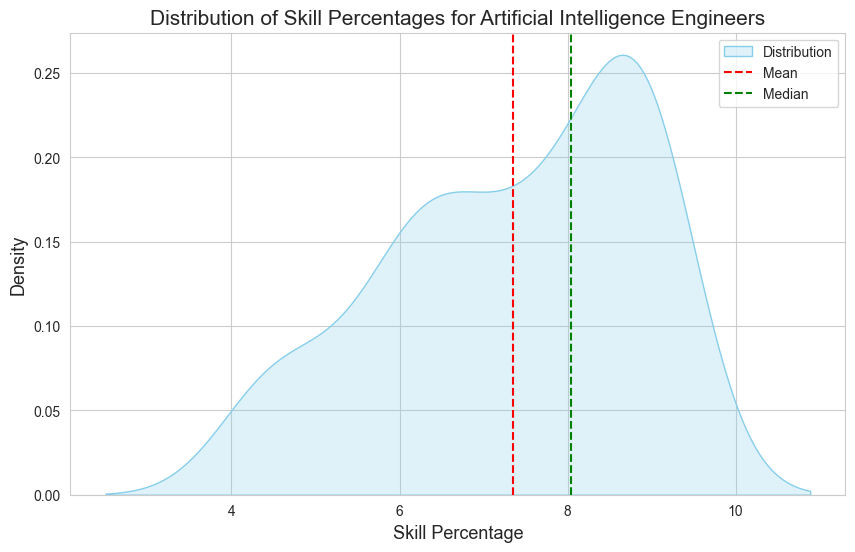

In [489]:
# make distribution plot for Artificial Intelligence
skill_ai_percentages = []

for skill in skills_name:
    skill_percentage = round(len(employee_skills_df[(employee_skills_df[skill]<=5)&
                     (employee_skills_df[skill]>=3)&
                     (employee_skills_df['Role']=='Artificial Intelligence Engineer')])/112*100,2)
    
    if skill_percentage >= 4:
        # print(skill,': ',f"{skill_percentage}%")
        skill_ai_percentages.append(skill_percentage)

# Create a distribution plot of the skill percentages
sns.set_style('whitegrid')
plt.figure(figsize=(10,6))
sns.kdeplot(skill_ai_percentages, shade=True, color='skyblue')
plt.axvline(x=np.mean(skill_ai_percentages), color='red', linestyle='--')
plt.axvline(x=np.median(skill_ai_percentages), color='green', linestyle='--')
plt.legend(['Distribution', 'Mean', 'Median'])

# Add labels and title
plt.xlabel('Skill Percentage', size=13)
plt.ylabel('Density', size=13)
plt.title('Distribution of Skill Percentages for Artificial Intelligence Engineers', size=15)
plt.show()

## 2.3. The Distribution of Employees that Over and Under Qualified the Task



In [490]:
result_moo

,employee,company,assigned_task,sum_sp,wasted_sp,assessment_score
0,Talent 1,['P3'],['T270'],8,12,[-0.027166504381694268]
1,Talent 2,"['P3', 'P3']","['T97', 'T166']",11,9,"[-0.017692307692307688, -0.017582417582417582]"
2,Talent 3,"['P2', 'P2']","['T201', 'T297']",11,9,"[-0.01773854560739807, -0.011648351648351648]"
3,Talent 4,"['P5', 'P5']","['T153', 'T296']",10,10,"[-0.01749788672865596, -0.011564986737400529]"
4,Talent 5,['P4'],['T39'],8,12,[-0.029608127721335267]
...,...,...,...,...,...,...
104,Talent 107,"['P4', 'P4', 'P4', 'P4', 'P4', 'P4', 'P4']","['T20', 'T37', 'T98', 'T124', 'T151', 'T190', ...",11,9,"[-3.416070845000482e-18, -0.000351648351648352..."
105,Talent 108,"['P4', 'P4']","['T81', 'T86']",10,10,"[-0.016374269005847958, -0.011263736263736269]"
106,Talent 109,"['P2', 'P2', 'P2']","['T69', 'T91', 'T229']",11,9,"[0.008245349421820009, 0.004321521175453759, 0..."
107,Talent 110,"['P5', 'P5', 'P5', 'P5', 'P5', 'P5', 'P5']","['T42', 'T90', 'T130', 'T143', 'T168', 'T169',...",11,9,"[-0.0016976127320954923, -0.00320082601961797,..."


In [491]:
result = {}
for idx, row in result_moo.iterrows():
    employee = row['employee']
    result[employee] = {        
        'company': ast.literal_eval(row['company']),
        'assigned_task': ast.literal_eval(row['assigned_task']),
        'sum_sp': row['sum_sp'],
        'wasted_sp': row['wasted_sp'],
        'assessment_score': ast.literal_eval(row['assessment_score'])
    }

In [492]:
result

{'Talent 1': {'company': ['P3'],
  'assigned_task': ['T270'],
  'sum_sp': 8,
  'wasted_sp': 12,
  'assessment_score': [-0.027166504381694268]},
 'Talent 2': {'company': ['P3', 'P3'],
  'assigned_task': ['T97', 'T166'],
  'sum_sp': 11,
  'wasted_sp': 9,
  'assessment_score': [-0.017692307692307688, -0.017582417582417582]},
 'Talent 3': {'company': ['P2', 'P2'],
  'assigned_task': ['T201', 'T297'],
  'sum_sp': 11,
  'wasted_sp': 9,
  'assessment_score': [-0.01773854560739807, -0.011648351648351648]},
 'Talent 4': {'company': ['P5', 'P5'],
  'assigned_task': ['T153', 'T296'],
  'sum_sp': 10,
  'wasted_sp': 10,
  'assessment_score': [-0.01749788672865596, -0.011564986737400529]},
 'Talent 5': {'company': ['P4'],
  'assigned_task': ['T39'],
  'sum_sp': 8,
  'wasted_sp': 12,
  'assessment_score': [-0.029608127721335267]},
 'Talent 6': {'company': ['P5', 'P5'],
  'assigned_task': ['T83', 'T242'],
  'sum_sp': 11,
  'wasted_sp': 9,
  'assessment_score': [-0.015746606334841626, -0.00968262506724

In [493]:
# Show employee and task in dict that has positive assessment score

overqualified = {}

for j, val in result.items():
    for task, score in zip(val['assigned_task'], val['assessment_score']):
        if score >= 0:
            overqualified[j] = (task, score)
            print(f'{j}: {task} with score = {score}')	

Talent 7: T14 with score = 0.0007239819004524844
Talent 7: T74 with score = 0.004102564102564103
Talent 7: T159 with score = 0.0005769230769230765
Talent 7: T222 with score = 0.0
Talent 8: T44 with score = 0.012725546058879385
Talent 8: T177 with score = 0.011442307692307694
Talent 8: T256 with score = 0.013529732678668851
Talent 8: T298 with score = 0.012307692307692308
Talent 10: T6 with score = 0.009194355939918068
Talent 10: T109 with score = 0.01135531135531136
Talent 10: T135 with score = 0.010657498925655345
Talent 19: T23 with score = 0.002750322303394927
Talent 19: T115 with score = 0.0003308519437551693
Talent 19: T173 with score = 0.00038703434929850014
Talent 19: T219 with score = 0.001190476190476188
Talent 19: T286 with score = 0.0005769230769230765
Talent 21: T49 with score = 0.008626056024899952
Talent 21: T164 with score = 0.006403748535728233
Talent 21: T165 with score = 0.006593406593406596
Talent 26: T258 with score = 0.0007918552036199084
Talent 26: T273 with score

In [494]:
print(f"Over-qualified Employees: {len(overqualified)}")

Over-qualified Employees: 27


In [495]:
# Show employee and task in dict that has negative assessment score

underqualified = {}

for j, val in result.items():
    for task, score in zip(val['assigned_task'], val['assessment_score']):
        if score < 0:
            underqualified[j] = (task, score)
            print(f'{j}: {task} with score = {score}')	

Talent 1: T270 with score = -0.027166504381694268
Talent 2: T97 with score = -0.017692307692307688
Talent 2: T166 with score = -0.017582417582417582
Talent 3: T201 with score = -0.01773854560739807
Talent 3: T297 with score = -0.011648351648351648
Talent 4: T153 with score = -0.01749788672865596
Talent 4: T296 with score = -0.011564986737400529
Talent 5: T39 with score = -0.029608127721335267
Talent 6: T83 with score = -0.015746606334841626
Talent 6: T242 with score = -0.00968262506724045
Talent 7: T174 with score = -0.0015755329008341013
Talent 7: T239 with score = -0.0013911620294599024
Talent 9: T278 with score = -0.017294429708222814
Talent 9: T289 with score = -0.016429249762583097
Talent 11: T94 with score = -0.007330924109447601
Talent 11: T212 with score = -0.004072398190045248
Talent 11: T253 with score = -0.0009483667017913563
Talent 12: T29 with score = -0.012326803631151458
Talent 12: T36 with score = -0.011317418213969945
Talent 13: T75 with score = -0.004033771106941837
T

In [496]:
print(f"Under-qualified Employees: {len(underqualified)}")

Under-qualified Employees: 95


In [497]:
# show assessment score in underqualified in descending order
sorted(underqualified.items(), key=lambda x: x[1][1])

[('Talent 103', ('T116', -0.03846153846153845)),
 ('Talent 17', ('T92', -0.035140815468684326)),
 ('Talent 112', ('T67', -0.031668331668331655)),
 ('Talent 5', ('T39', -0.029608127721335267)),
 ('Talent 82', ('T11', -0.029479502533394764)),
 ('Talent 56', ('T170', -0.029222174473571127)),
 ('Talent 85', ('T285', -0.028698224852071)),
 ('Talent 1', ('T270', -0.027166504381694268)),
 ('Talent 100', ('T161', -0.026829268292682937)),
 ('Talent 44', ('T250', -0.02648018648018649)),
 ('Talent 34', ('T290', -0.026452684006640834)),
 ('Talent 74', ('T134', -0.026358974358974357)),
 ('Talent 78', ('T118', -0.025982905982905986)),
 ('Talent 49', ('T257', -0.02523076923076922)),
 ('Talent 35', ('T226', -0.02493368700265252)),
 ('Talent 81', ('T276', -0.024226348364279397)),
 ('Talent 89', ('T101', -0.02393162393162393)),
 ('Talent 29', ('T154', -0.023269230769230764)),
 ('Talent 20', ('T251', -0.022271914132379257)),
 ('Talent 18', ('T215', -0.021939007737824312)),
 ('Talent 51', ('T183', -0.0207

In [498]:
over_set = set(overqualified.keys())
under_set = set(underqualified.keys())
intersection = over_set.intersection(under_set)

In [499]:
intersection

{'Talent 107',
 'Talent 26',
 'Talent 28',
 'Talent 31',
 'Talent 45',
 'Talent 46',
 'Talent 47',
 'Talent 52',
 'Talent 58',
 'Talent 7',
 'Talent 83',
 'Talent 91',
 'Talent 94'}

In [500]:
over_set = over_set - intersection
under_set = under_set - intersection
print(len(over_set))
print(len(under_set))

14
82


In [501]:
over_set

{'Talent 10',
 'Talent 104',
 'Talent 109',
 'Talent 19',
 'Talent 21',
 'Talent 39',
 'Talent 42',
 'Talent 50',
 'Talent 62',
 'Talent 70',
 'Talent 73',
 'Talent 8',
 'Talent 92',
 'Talent 99'}

In [502]:
under_set

{'Talent 1',
 'Talent 100',
 'Talent 101',
 'Talent 102',
 'Talent 103',
 'Talent 105',
 'Talent 106',
 'Talent 108',
 'Talent 11',
 'Talent 110',
 'Talent 112',
 'Talent 12',
 'Talent 13',
 'Talent 14',
 'Talent 15',
 'Talent 16',
 'Talent 17',
 'Talent 18',
 'Talent 2',
 'Talent 20',
 'Talent 22',
 'Talent 23',
 'Talent 24',
 'Talent 25',
 'Talent 27',
 'Talent 29',
 'Talent 3',
 'Talent 30',
 'Talent 34',
 'Talent 35',
 'Talent 36',
 'Talent 37',
 'Talent 38',
 'Talent 4',
 'Talent 40',
 'Talent 41',
 'Talent 43',
 'Talent 44',
 'Talent 48',
 'Talent 49',
 'Talent 5',
 'Talent 51',
 'Talent 53',
 'Talent 54',
 'Talent 55',
 'Talent 56',
 'Talent 57',
 'Talent 59',
 'Talent 6',
 'Talent 60',
 'Talent 61',
 'Talent 63',
 'Talent 64',
 'Talent 65',
 'Talent 66',
 'Talent 67',
 'Talent 68',
 'Talent 69',
 'Talent 71',
 'Talent 72',
 'Talent 74',
 'Talent 75',
 'Talent 76',
 'Talent 77',
 'Talent 78',
 'Talent 79',
 'Talent 80',
 'Talent 81',
 'Talent 82',
 'Talent 84',
 'Talent 85',
 'T

## 2.4. Over and Underqualified Employees by Role

In [505]:
employee_index_df = pd.read_csv(new_employee_path, index_col='No').set_index('employee_id')
employee_index_df.head()

,Role,Mathematics.Linear Algebra,Mathematics.Differential Equations,Mathematics.Optimization Technique,Mathematics.Calculus,Mathematics.Combinatorics & Graph,Statistics & Probabilities.Statistics,Statistics & Probabilities.Probability & Sampling,Statistics & Probabilities.Bayessian Method,Statistics & Probabilities.Hypothesis Testing,...,Data & Cloud Engineering.Data Security & Privacy,Data & Cloud Engineering.Distributed Systems,"Data & Cloud Engineering.Monitoring, Logging, Alerting",MLOPS.ML Lifecycle,MLOPS.ML Model Pipeline,MLOPS.Model Versioning,MLOPS.Automated Testing & Validation,MLOPS.Scalable Model Training,"MLOPS.Model Deployment, Monitoring, Logging",MLOPS.Ethical AI & Bias Mitigation
employee_id,,,,,,,,,,,,,,,,,,,,,
Talent 1,Data Scientist,1,1,2,1,2,3,3,2,2,...,1,1,1,2,1,1,1,1,1,2
Talent 2,Data Scientist,4,4,4,4,3,5,4,3,3,...,3,2,1,1,1,1,1,1,1,1
Talent 3,Data Analyst,3,2,2,3,2,3,3,2,2,...,3,3,3,3,2,3,2,3,3,2
Talent 4,Data Scientist,3,2,3,2,3,4,3,2,4,...,3,1,1,2,2,2,2,2,2,2
Talent 5,Data Analyst,2,1,3,1,1,1,2,1,1,...,2,1,1,3,2,5,2,1,2,1


In [524]:
roles = set(employee_index_df['Role'])

role_over_qualified = {}

for role in roles:
    temp = []
    for j in employee_index_df.index:
        if j in over_set and employee_index_df.loc[j, 'Role'] == role:
            temp.append(j)
    role_over_qualified[role] = temp

role_over_qualified

{'Data Analyst': ['Talent 70', 'Talent 92'],
 'Artificial Intelligence Engineer': ['Talent 21',
  'Talent 50',
  'Talent 73',
  'Talent 104'],
 'Data Engineer': ['Talent 62', 'Talent 99', 'Talent 109'],
 'Data Scientist': ['Talent 8',
  'Talent 10',
  'Talent 19',
  'Talent 39',
  'Talent 42']}

In [526]:
role_under_qualified = {}

for role in roles:
    temp = []
    for j in employee_index_df.index:
        if j in under_set and employee_index_df.loc[j, 'Role'] == role:
            temp.append(j)
    role_under_qualified[role] = temp

role_under_qualified['Data Engineer']

['Talent 9',
 'Talent 11',
 'Talent 13',
 'Talent 24',
 'Talent 25',
 'Talent 38',
 'Talent 40',
 'Talent 48',
 'Talent 53',
 'Talent 54',
 'Talent 80',
 'Talent 97']

In [527]:
role_intersection = {}

for role in roles:
    temp = []
    for j in employee_index_df.index:
        if j in intersection and employee_index_df.loc[j, 'Role'] == role:
            temp.append(j)
    role_intersection[role] = temp

role_intersection

{'Data Analyst': ['Talent 31', 'Talent 94', 'Talent 107'],
 'Artificial Intelligence Engineer': ['Talent 28', 'Talent 52'],
 'Data Engineer': ['Talent 46'],
 'Data Scientist': ['Talent 7',
  'Talent 26',
  'Talent 45',
  'Talent 47',
  'Talent 58',
  'Talent 83',
  'Talent 91']}

### 2.4.1. Artificial Intelligence Pie Chart

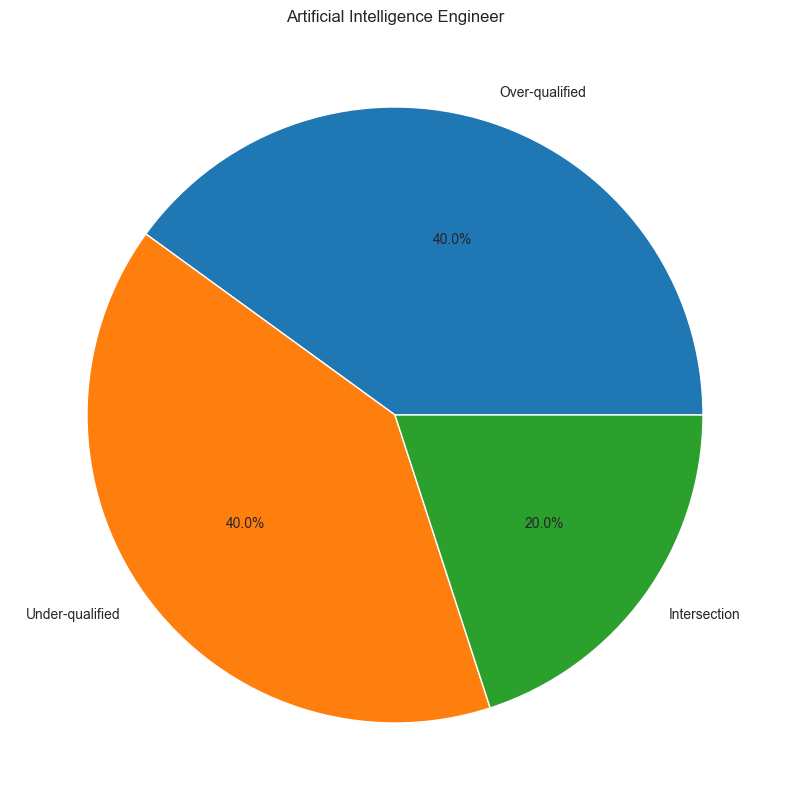

In [528]:
# make 3d pie chart by AI
plt.figure(figsize=(10, 10))
plt.pie([len(role_over_qualified['Artificial Intelligence Engineer']), len(role_under_qualified['Artificial Intelligence Engineer']), len(role_intersection['Artificial Intelligence Engineer'])], labels=['Over-qualified', 'Under-qualified', 'Intersection'], autopct='%1.1f%%')
plt.title('Artificial Intelligence Engineer')
plt.show()

### 2.4.2. Data Analyst

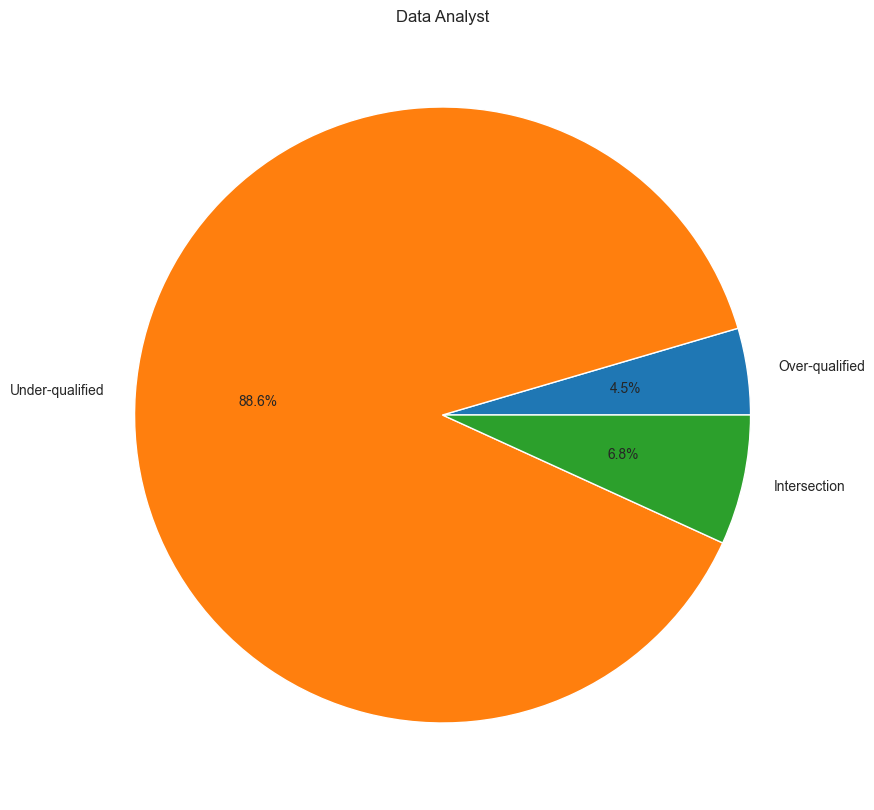

In [529]:
plt.figure(figsize=(10, 10))
plt.pie([len(role_over_qualified['Data Analyst']), len(role_under_qualified['Data Analyst']), len(role_intersection['Data Analyst'])], labels=['Over-qualified', 'Under-qualified', 'Intersection'], autopct='%1.1f%%')
plt.title('Data Analyst')
plt.show()

### 2.4.3. Data Engineer

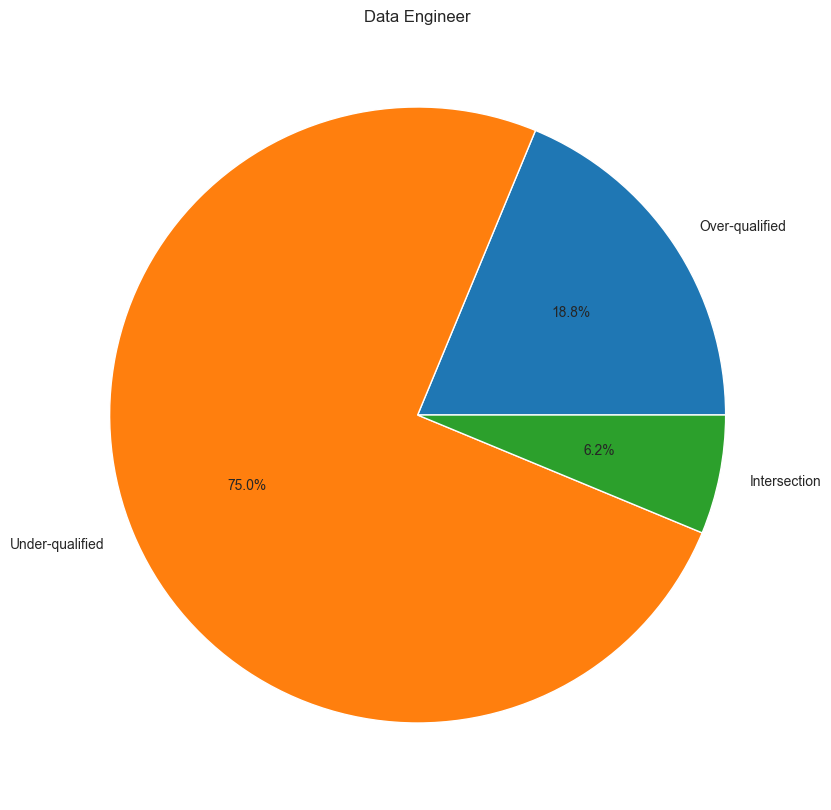

In [531]:
plt.figure(figsize=(10, 10))
plt.pie([len(role_over_qualified['Data Engineer']), len(role_under_qualified['Data Engineer']), len(role_intersection['Data Engineer'])], labels=['Over-qualified', 'Under-qualified', 'Intersection'], autopct='%1.1f%%')
plt.title('Data Engineer')
plt.show()

### 2.4.2. Data Scientist

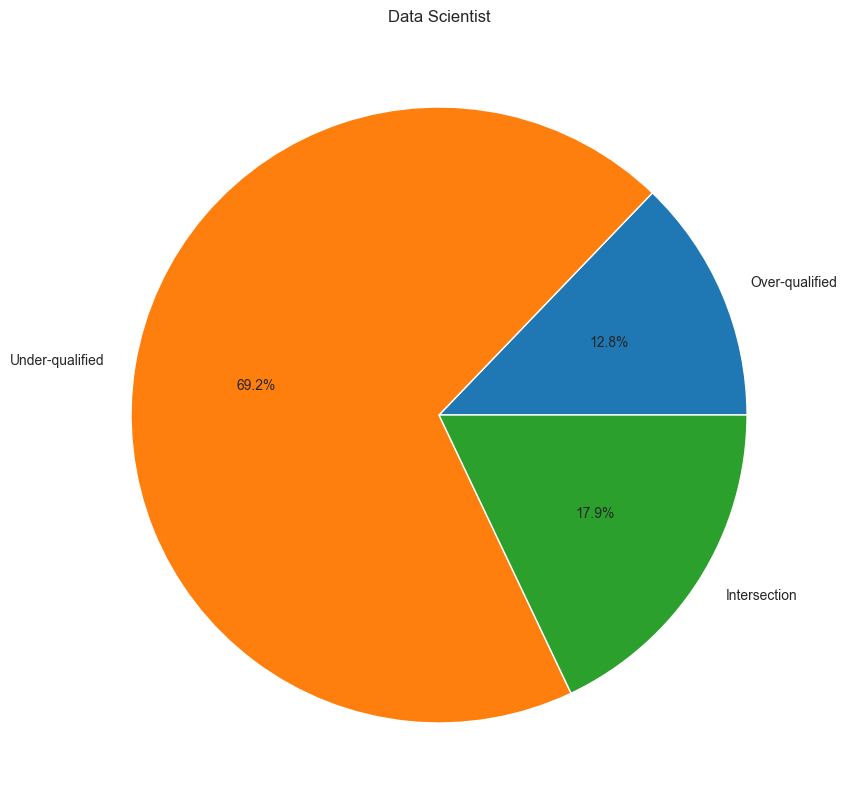

In [532]:
plt.figure(figsize=(10, 10))
plt.pie([len(role_over_qualified['Data Scientist']), len(role_under_qualified['Data Scientist']), len(role_intersection['Data Scientist'])], labels=['Over-qualified', 'Under-qualified', 'Intersection'], autopct='%1.1f%%')
plt.title('Data Scientist')
plt.show()

In [ ]:
# Show the dict sort by assessment score in ascending order
for j, val in result.items():
    # print(j)
    for task, score in sorted(zip(val['assigned_task'], val['assessment_score']), key=lambda x: x[1]):
        print(f'{j}: {task} with score = {score}')

Talent 1: T270 with score = -0.027166504381694268
Talent 2: T97 with score = -0.017692307692307688
Talent 2: T166 with score = -0.017582417582417582
Talent 3: T201 with score = -0.01773854560739807
Talent 3: T297 with score = -0.011648351648351648
Talent 4: T153 with score = -0.01749788672865596
Talent 4: T296 with score = -0.011564986737400529
Talent 5: T39 with score = -0.029608127721335267
Talent 6: T83 with score = -0.015746606334841626
Talent 6: T242 with score = -0.00968262506724045
Talent 7: T174 with score = -0.0015755329008341013
Talent 7: T239 with score = -0.0013911620294599024
Talent 7: T222 with score = 0.0
Talent 7: T159 with score = 0.0005769230769230765
Talent 7: T14 with score = 0.0007239819004524844
Talent 7: T74 with score = 0.004102564102564103
Talent 8: T177 with score = 0.011442307692307694
Talent 8: T298 with score = 0.012307692307692308
Talent 8: T44 with score = 0.012725546058879385
Talent 8: T256 with score = 0.013529732678668851
Talent 9: T278 with score = -0

kalo ada employee yg under, bisa fokusin situ sebagai insight apakah skill yang under memang cocok atau tidak sama employeenya, barangkali yg bikin jadi under karna skill ini.
